In [64]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs

import xarray as xr
import xstatstests as xst

import sys
import os.path as op


from dask.distributed import Client

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
SERVER = 'IAC'
# SERVER = 'LOCAL'
if SERVER == 'IAC':
    CODE_ROOT = '/home/qnicolas/'
elif SERVER == 'LOCAL':
    CODE_ROOT = '/Users/qnicolas/'
else:
    raise ValueError('SERVER not recognized. Set SERVER to IAC or LOCAL.')

DATA_ROOT = op.join(CODE_ROOT, 'stationaryWave/data/')
for p in [op.join(CODE_ROOT, 'iac_notebooks/tools/'),
          op.join(CODE_ROOT, 'stationaryWave/src/'),]:
    if p not in sys.path:
        sys.path.append(p)

from generalTools import ddx, ddy, sel_months, quickplot, lon_360_to_180, wrap_lon, invert_latitudes, sel_box, add_gridlines, spatial_mean, plot_quiver


In [40]:
client = Client(n_workers=8, threads_per_worker=1, memory_limit='20GB',dashboard_address=':30000')

In [3]:
en_years = np.array([1982,1987,1991,1997,2002,2004,2009,2015])

In [30]:
import matplotlib.patches as mpatches
class Region :
    def __init__(self, name, box, months, color):
        self.name=name
        self.box=box
        self.months=months
        self.vars={}
        self.color=color
        self._monthstr = '-'.join(["{:02}".format(m) for m in self.months])

    def plot_box(self,ax):
        ax.add_patch(mpatches.Rectangle(xy=[self.box[0], self.box[2]], width=self.box[1]-self.box[0], height=self.box[3]-self.box[2],
                     edgecolor=self.color,
                     fill = False,
                     lw=1,
                     linestyle='-',
                     transform=ccrs.PlateCarree()))


In [20]:
subtropics_N_box = [-20,110,15,40]
subtropics_S_box = [-20,110,-40,-15]
def get_cold_index(T):
    return (sel_box(T,subtropics_S_box).mean(['latitude','longitude']) + sel_box(T,subtropics_N_box).mean(['latitude','longitude'])) / 2

In [47]:
APIndia = Region("Arabian Peninsula - India",[40,90,15,40],[],'r')


# Evaluate U, W, Q anomalies during developing EN years in ERA5

In [4]:
era5_monthly_2deg = xr.open_dataset("/net/helium/atmosdyn/qnicolas/era5monthly/e5.monthly.all.2deg.1980-2020.nc")

[iacdipl-6:48963] pml_ucx.c:313  Error: Failed to create UCP worker


[1765547857.144831] [iacdipl-6:48963:0]           ib_md.c:282  UCX  ERROR ibv_reg_mr(address=0x7f0b3d800000, length=39845888, access=0xf) failed: Cannot allocate memory : Please set max locked memory (ulimit -l) to 'unlimited' (current: 8192 kbytes)
[1765547857.144886] [iacdipl-6:48963:0]           mpool.c:269  UCX  ERROR Failed to allocate memory pool (name=rc_recv_desc) chunk: Input/output error
[1765547857.149761] [iacdipl-6:48963:0]         ib_mlx5.c:127  UCX  ERROR mlx5_bond_0: mlx5dv_create_cq(cqe=4096) failed: Cannot allocate memory : Please set max locked memory (ulimit -l) to 'unlimited' (current: 8192 kbytes)
[1765547857.150000] [iacdipl-6:48963:0]      ucp_worker.c:1413 UCX  ERROR uct_iface_open(ud_mlx5/mlx5_bond_0:1) failed: Input/output error


In [11]:
era5_monthly_2deg_jjamean = sel_months(era5_monthly_2deg[['U','V','W','Q','T']],[6,7,8]).coarsen(time=3).mean()

In [12]:
era5_monthly_2deg_jjamean_allmean = era5_monthly_2deg_jjamean.mean('time')

In [13]:
era5_monthly_2deg_jja_en_anom = era5_monthly_2deg_jjamean.isel(time=np.array(en_years)-1980).mean('time') - era5_monthly_2deg_jjamean_allmean

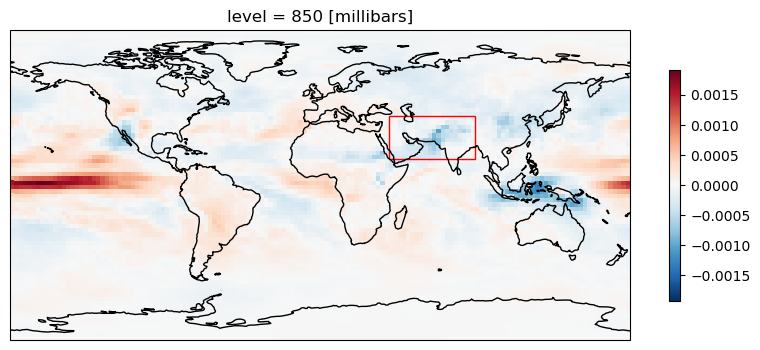

In [36]:
ax = quickplot(era5_monthly_2deg_jja_en_anom.Q.sel(level=850),cmap='RdBu_r')
IndiaPak.plot_box(ax)

In [48]:
test = spatial_mean(era5_monthly_2deg_jjamean.Q.sel(level=slice(600,900)).mean('level'),box = APIndia.box)

Text(0.5, 1.0, 'Arabian peninsula & India JJA specific humidity (600-900 hPa)\nred = developing EN')

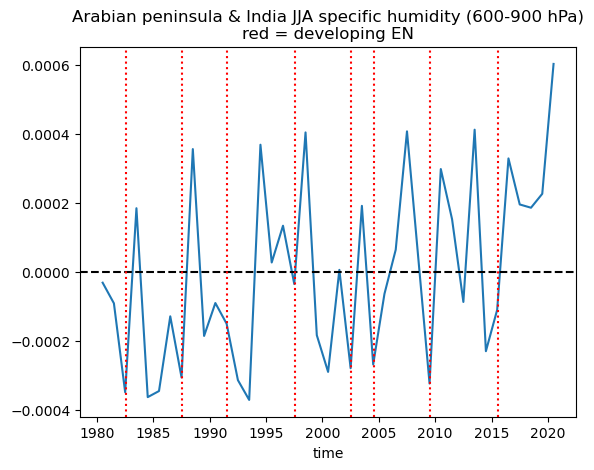

In [49]:
(test-test.mean()).plot()
plt.axhline(0.0, color='k', linestyle='--')
for year in en_years:
    plt.axvline(np.datetime64(f'{year}-07-15'), color='r', linestyle=':')
plt.title('Arabian peninsula & India JJA specific humidity (600-900 hPa)\nred = developing EN')

Text(0.5, 1.0, 'JJA EN composite 850 hPa specific humidity anomalies + 850 mb winds')

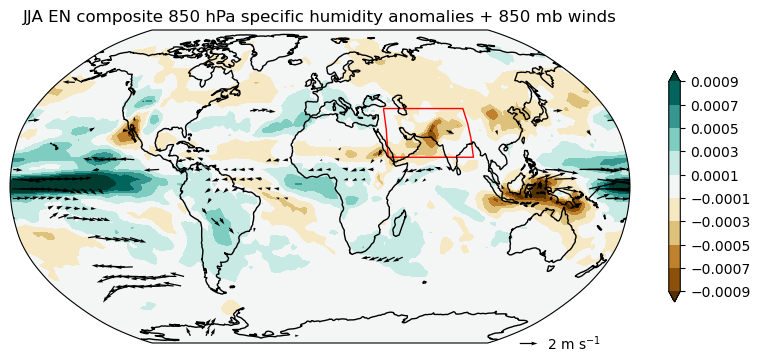

In [85]:
ax = quickplot(wrap_lon(era5_monthly_2deg_jja_en_anom).Q.sel(level=850),cmap='BrBG',fast=False,levels = np.arange(-9,9.1,2) * 1e-4,extend='both')
IndiaPak.plot_box(ax)

speed = np.sqrt(era5_monthly_2deg_jjamean.U**2 + era5_monthly_2deg_jjamean.V**2).to_dataset(name='speed')
pval = xst.ttest_ind( speed.isel(time=np.array(en_years)-1980),  speed,dim='time').pvalue
pval = wrap_lon(pval).sel(level=850.)

plot_quiver(ax,
            era5_monthly_2deg_jja_en_anom.U.sel(level=850).where(pval<0.05),
            era5_monthly_2deg_jja_en_anom.V.sel(level=850).where(pval<0.05),
            step=2,scale=70,width=0.002,qk=True,qk_scale=2,qk_pos = (0.85,0.))
ax.set_title('JJA EN composite 850 hPa specific humidity anomalies + 850 mb winds')

Text(0.5, 1.0, 'JJA EN composite 500 hPa specific humidity anomalies + 850 mb winds')

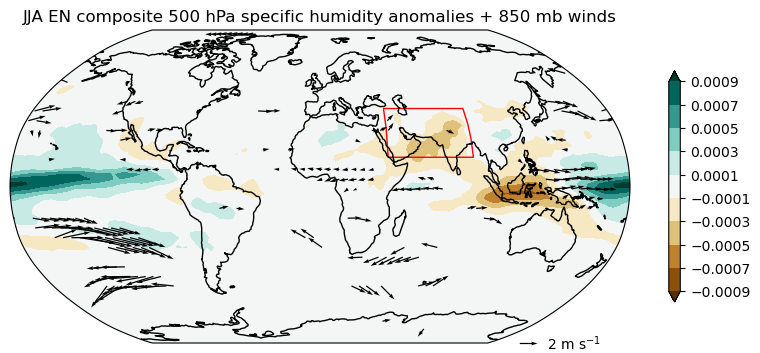

In [90]:
ax = quickplot(wrap_lon(era5_monthly_2deg_jja_en_anom).Q.sel(level=500),cmap='BrBG',fast=False,levels = np.arange(-9,9.1,2) * 1e-4,extend='both')
IndiaPak.plot_box(ax)

speed = np.sqrt(era5_monthly_2deg_jjamean.U**2 + era5_monthly_2deg_jjamean.V**2).to_dataset(name='speed')
pval = xst.ttest_ind( speed.isel(time=np.array(en_years)-1980),  speed,dim='time').pvalue
pval = wrap_lon(pval).sel(level=500.)

plot_quiver(ax,
            era5_monthly_2deg_jja_en_anom.U.sel(level=500).where(pval<0.05),
            era5_monthly_2deg_jja_en_anom.V.sel(level=500).where(pval<0.05),
            step=2,scale=70,width=0.002,qk=True,qk_scale=2,qk_pos = (0.85,0.))
ax.set_title('JJA EN composite 500 hPa specific humidity anomalies + 850 mb winds')

Text(0.5, 1.0, 'JJA EN composite 500 hPa vertical velocity anomalies (Pa/s) + 300 hPa winds')

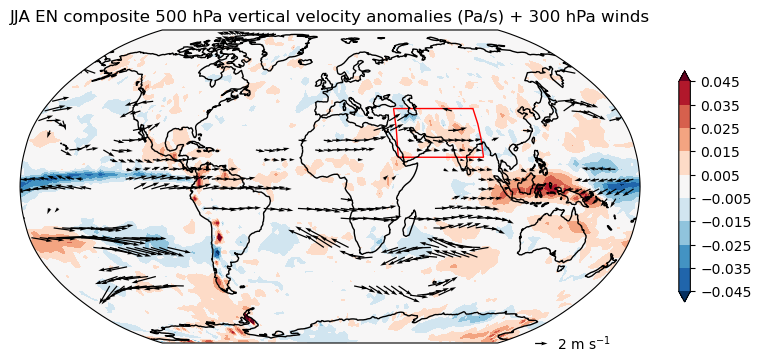

In [93]:
ax = quickplot(wrap_lon(era5_monthly_2deg_jja_en_anom).W.sel(level=500),cmap='RdBu_r',fast=False,levels = np.arange(-9,9.1,2) * 5e-3)
IndiaPak.plot_box(ax)

speed = np.sqrt(era5_monthly_2deg_jjamean.U**2 + era5_monthly_2deg_jjamean.V**2).to_dataset(name='speed')
pval = xst.ttest_ind( speed.isel(time=np.array(en_years)-1980),  speed,dim='time').pvalue
pval = wrap_lon(pval).sel(level=300.)

plot_quiver(ax,
            era5_monthly_2deg_jja_en_anom.U.sel(level=300).where(pval<0.05),
            era5_monthly_2deg_jja_en_anom.V.sel(level=300).where(pval<0.05),
            step=2,scale=100,width=0.002,qk=True,qk_scale=2,qk_pos = (0.85,0.))
ax.set_title('JJA EN composite 500 hPa vertical velocity anomalies (Pa/s) + 300 hPa winds')

# Evaluate variability